# Model Training

## install and import

In [ ]:
pip install deepchem

In [ ]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import deepchem as dc
import rdkit
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors

from sklearn.model_selection import KFold
from deepchem.splits.splitters import ScaffoldSplitter
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression # stacking모델
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import Ridge, Lasso

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras import models
from deepchem.models.graph_models import GraphConvModel

import joblib
import pickle
import datetime
import pytz

## Data Load and Preprocessing

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/약물대사예측/train.csv')
test = pd.read_csv('/content/drive/MyDrive/약물대사예측/test.csv')

train = train.loc[:,['SMILES','MLM','HLM']] # Only SMILES 만
test = test.loc[:,['SMILES']]  # Only SMILES 만

In [ ]:
dup = train[train.SMILES.duplicated(keep=False)].sort_values(by='SMILES')

dif_dup = dup.groupby('SMILES').agg(lambda x: x.max() - x.min()).sort_values(['HLM','MLM'],ascending=False)
high_err = dif_dup[(dif_dup['HLM'] >= 40) | (dif_dup['MLM'] >= 40)]

check = train.drop_duplicates(subset='SMILES', keep = False)



dup_except_er = dup.drop(dup[dup['SMILES'].isin(high_err.index)].index) #이렇게하면 총 9쌍이 빠지니까 54-18 = 36
print(f'smiles 겹치는 게 총 {len(dup)}개, 겹친것중 값차이가 많이나는게 {len(high_err)*2}개, 차이나는거 빼주면 {len(dup_except_er)}개')

max_dup = dup_except_er.groupby('SMILES').agg(lambda x: x.max()) #남은 36쌍 중 18개 남음
print(f'남은 것중에 max값 기준으로만 남기면 {len(max_dup)}개')

max_dup = max_dup.reset_index()

train = pd.concat([check,max_dup],axis=0)

train.reset_index(inplace=True)
train.drop('index',axis=1,inplace=True)

smiles 겹치는 게 총 54개, 겹친것중 값차이가 많이나는게 18개, 차이나는거 빼주면 36개
남은 것중에 max값 기준으로만 남기면 18개


In [ ]:
# MAX
train.loc[train['HLM'] >= 100,'HLM'] = 100
train.loc[train['MLM'] >= 100,'MLM'] = 100

## Feature Enginnering

In [ ]:
train.columns[:3]

Index(['SMILES', 'MLM', 'HLM'], dtype='object')

In [ ]:
rdk_list = ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'AvgIpc',
       'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n',
       'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
       'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA',
       'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA6',
       'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10',
       'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SlogP_VSA1',
       'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA6', 'TPSA',
       'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4',
       'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
       'EState_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState3',
       'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7',
       'VSA_EState8', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount',
       'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'RingCount', 'MolLogP', 'MolMR', 'fr_Ar_N', 'fr_NH0', 'fr_benzene']

In [ ]:
# 0D-Descriptor : RDKit Descriptor
def get_descriptor_feature(train_df,test_df, min_max_mean = True):

  PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES')
  PandasTools.AddMoleculeColumnToFrame(test_df,'SMILES')

  train_mol = train_df.ROMol
  test_mol = test_df.ROMol

  train_rdk = {}
  test_rdk = {}

  for i,j in Descriptors.descList: # RDkit Descrpior 적용
    train_rdk[i] = train_mol.apply(j)
    test_rdk[i] = test_mol.apply(j)

  if min_max_mean:
    try:
      train_rdk['MaxAbsPartialCharge'] = np.where(pd.isna(train_rdk['MaxAbsPartialCharge']), train_rdk['MaxAbsPartialCharge'].mean() ,train_rdk['MaxAbsPartialCharge'])
      train_rdk['MinAbsPartialCharge'] = np.where(pd.isna(train_rdk['MinAbsPartialCharge']), train_rdk['MinAbsPartialCharge'].mean() ,train_rdk['MinAbsPartialCharge'])
    except:
      pass
    try:
      test_rdk['MaxAbsPartialCharge'] = np.where(pd.isna(test_rdk['MaxAbsPartialCharge']), test_rdk['MaxAbsPartialCharge'].mean() ,test_rdk['MaxAbsPartialCharge'])
      test_rdk['MinAbsPartialCharge'] = np.where(pd.isna(test_rdk['MinAbsPartialCharge']), test_rdk['MinAbsPartialCharge'].mean() ,test_rdk['MinAbsPartialCharge'])
    except:
      pass

  train_rdk = pd.DataFrame(train_rdk)
  test_rdk = pd.DataFrame(test_rdk)

  null_list = list(train_rdk.isnull().sum()[train_rdk.isnull().sum() > 0].keys())
  print('결측치 있는 것 :',null_list)

  # 나머지 na 있는건 걍 삭제해버리기
  train_rdk.drop(null_list,axis=1,inplace=True)
  test_rdk.drop(null_list,axis=1,inplace=True)

  # 0 이 너무 많은것도 삭제하자
  zero_columns = []
  for i in train_rdk.columns:
    zero_count = (train_rdk[f'{i}'] == 0).sum()
    if zero_count > len(train_rdk)/3:
      zero_columns.append(i)
  print('0이 많은것 :',zero_columns)
  train_rdk.drop(zero_columns,axis=1,inplace=True)
  test_rdk.drop(zero_columns,axis=1,inplace=True)

  # ROMol 없애기
  train_df.drop('ROMol',axis=1,inplace=True)
  test_df.drop('ROMol',axis=1,inplace=True)

  return train_rdk, test_rdk

In [ ]:
# Fingerprint Descriptor
class FpsGenerator:
    def __init__(self, size=2048, radius=4):
        self.featurizer = dc.feat.CircularFingerprint(size=size, radius=radius)

    def generate_fingerprints(self, df):
        list_fps = df['SMILES'].apply(self.featurizer.featurize)
        fps_features = np.vstack(list_fps)
        fps_df = pd.DataFrame(fps_features)
        fps_df.columns = fps_df.columns.astype(str)
        return fps_df

featurizer = FpsGenerator(size=2048, radius=4)

In [ ]:
# Mol2Vec Fingerprint
class Mol2Vec:
  def __init__(self):
    self.featurizer = dc.feat.Mol2VecFingerprint()

  def generate_mol2vecDataFrame(self, df):
    list_vec = df['SMILES'].apply(self.featurizer.featurize)
    vec_features = np.vstack(list_vec)
    vec_df = pd.DataFrame(vec_features)
    vec_df.columns = vec_df.columns.astype(str)
    return vec_df

vec_featurizer = Mol2Vec()

In [ ]:
# ConvMolFeaturizer
class ConvMol:
  def __init__(self):
    self.featurizer = dc.feat.ConvMolFeaturizer()

  def generate_Convmoldata(self, df):
    mols = [Chem.MolFromSmiles(s) for s in df.SMILES]
    conv_list = self.featurizer.featurize(mols)
    conv_df = pd.DataFrame({'conv':conv_list})
    return conv_df

conv_featurizer = ConvMol()

In [ ]:
# RDKit Descriptor
train_rdk_df, test_rdk_df = get_descriptor_feature(train,test,min_max_mean=True)
# 병합
train_rdk = pd.concat([train,train_rdk_df],axis=1)
test_rdk = pd.concat([test,test_rdk_df],axis=1)

# train에 대한 Circular Fingerprint 생성
train_fps_df = featurizer.generate_fingerprints(train)
# test에 대한 Circular Fingerprint 생성
test_fps_df = featurizer.generate_fingerprints(test)
# 병합
train_fps = pd.concat([train.iloc[:,:3],train_fps_df],axis=1)
test_fps = pd.concat([test.iloc[:,:1],test_fps_df],axis=1)

# Mol2Vec
train_vec_df = vec_featurizer.generate_mol2vecDataFrame(train)
test_vec_df = vec_featurizer.generate_mol2vecDataFrame(test)
train_vec = pd.concat([train.iloc[:,:3],train_vec_df],axis=1)
test_vec = pd.concat([test.iloc[:,:1],test_vec_df],axis=1)

# train에 대한 conv_list 생성
train_conv_df = conv_featurizer.generate_Convmoldata(train)
# test에 대한 conv_list 생성
test_conv_df = conv_featurizer.generate_Convmoldata(test)
# 병합
train_conv = pd.concat([train.iloc[:,:3],train_conv_df],axis=1)
test_conv = pd.concat([test.iloc[:,:1],test_conv_df],axis=1)

결측치 있는 것 : ['MaxPartialCharge', 'MinPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
0이 많은것 : ['NumRadicalElectrons', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA4', 'PEOE_VSA5', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA4', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'EState_VSA1', 'EState_VSA11', 'VSA_EState10', 'VSA_EState9', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid

## Split Dataset / label

In [ ]:
class DataSplitter:
  def __init__(self,seed=42):
    self.seed = seed

  def create_dataframe(self,df):
    dataset = dc.data.NumpyDataset(X=np.array(df.iloc[:,:3]), ids = df['SMILES'])
    # train / valid dataset split for ScaffoldSplitter
    splitter = dc.splits.ScaffoldSplitter()
    train_dataset, valid_dataset = splitter.train_test_split(dataset, frac_train=0.86, seed=self.seed)
    # train / valid df split
    train_df = df[df['SMILES'].isin(train_dataset.ids)]
    valid_df = df[df['SMILES'].isin(valid_dataset.ids)]
    return train_df, valid_df
data_splitter = DataSplitter()

In [ ]:
# 분자 특성 추가한것만 나누기 - 0D Descriptor
train_df_rdk, valid_df_rdk = data_splitter.create_dataframe(train_rdk)

# fps 합친거로 나누기 - 1D Descriptor
train_df_fps, valid_df_fps = data_splitter.create_dataframe(train_fps)

# vec 합친거로 나누기 - 1D Descriptpr
train_df_vec, valid_df_vec = data_splitter.create_dataframe(train_vec)

# Conv 합친거로 나누기(Dataset 이용 요망) - 2D Descriptor
train_df_conv, valid_df_conv = data_splitter.create_dataframe(train_conv)

#dataset 만들어주기 - convmol
train_conv_dataset = dc.data.NumpyDataset(X=np.array(train_df_conv.iloc[:,3]), y=train_df_conv.iloc[:,1:3])
valid_conv_dataset = dc.data.NumpyDataset(X=np.array(valid_df_conv.iloc[:,3]), y=valid_df_conv.iloc[:,1:3])
test_conv_dataset = dc.data.NumpyDataset(X=np.array(test_conv.iloc[:,1]))

In [ ]:
test_conv_dataset

<NumpyDataset X.shape: (483,), y.shape: (483, 1), w.shape: (483, 1), ids: [0 1 2 ... 480 481 482], task_names: [0]>

In [ ]:
def feature_label_split(train_df,valid_df):
  hlm_loc = train_df.columns.get_loc('HLM')
  mlm_loc = train_df.columns.get_loc('MLM')
  train_feature = train_df.iloc[:,hlm_loc+1:]
  train_label = train_df.iloc[:,mlm_loc:hlm_loc+1]

  valid_feature = valid_df.iloc[:,hlm_loc+1:]
  valid_label = valid_df.iloc[:,mlm_loc:hlm_loc+1]
  print(f'train_feature, train_label, valid_feature, valid_label 로 저장됨')
  return train_feature, train_label, valid_feature, valid_label

In [ ]:
train_rdk_feature, train_rdk_label, valid_rdk_feature, valid_rdk_label = feature_label_split(train_df_rdk,valid_df_rdk)
train_fps_feature, train_fps_label, valid_fps_feature, valid_fps_label = feature_label_split(train_df_fps,valid_df_fps)
train_vec_feature, train_vec_label, valid_vec_feature, valid_vec_label = feature_label_split(train_df_vec,valid_df_vec)

train_feature, train_label, valid_feature, valid_label 로 저장됨
train_feature, train_label, valid_feature, valid_label 로 저장됨
train_feature, train_label, valid_feature, valid_label 로 저장됨


In [ ]:
# FPs 및 rdk는 합쳐주기
train_sum = pd.concat([train_rdk_feature,train_fps_feature],axis=1)
valid_sum = pd.concat([valid_rdk_feature,valid_fps_feature],axis=1)

## Modeling

In [ ]:
seed = 42
dropout = 0.3

In [ ]:
# if you need transform to numpy
train_vec_feature_np = train_vec_feature.to_numpy()
valid_vec_feature_np = valid_vec_feature.to_numpy()
train_vec_label_np = train_vec_label.to_numpy()
valid_vec_label_np = valid_vec_label.to_numpy()

# Reshape the input data to match the expected 3D shape
train_vec_feature_np = train_vec_feature_np.reshape(train_vec_feature_np.shape[0],train_vec_feature_np.shape[1], 1)
valid_vec_feature_np = valid_vec_feature_np.reshape(valid_vec_feature_np.shape[0],valid_vec_feature_np.shape[1], 1)

In [ ]:
def show_reg_result(y_test, y_pred, N=50):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    max_err = np.abs(y_test - y_pred).max()

    print('MAE:', round(mae, 4))
    print('RMSE:', round(rmse,4))
    print('Max error:', round(max_err, 4))

    # 일부 실제값과 예측값 샘플을 plot으로 비교하여 그려본다 (N 개)

    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.xlim(-1,N+1)
      plt.legend()
      plt.ylabel('MLM/HLM')
      plt.show()

MAE: 26.7178
RMSE: 31.8736
Max error: MLM    83.3178
HLM    80.5453
dtype: float64


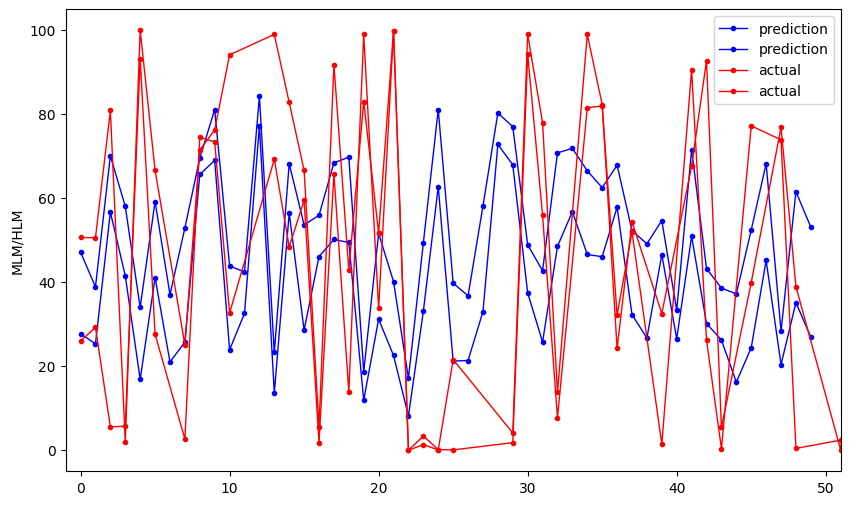

In [ ]:
# RF 기본으로 써보기
rf_model_sum = RandomForestRegressor(random_state=seed)
rf_model_sum.fit(train_sum, train_fps_label)
pred_sum_label_rf = rf_model_sum.predict(valid_sum)
show_reg_result(valid_fps_label,pred_sum_label_rf) #RMSE: 31.8736

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:35.41992
[1]	validation_0-rmse:35.06938
[2]	validation_0-rmse:34.76408
[3]	validation_0-rmse:34.48157
[4]	validation_0-rmse:34.24274
[5]	validation_0-rmse:34.00651
[6]	validation_0-rmse:33.80398
[7]	validation_0-rmse:33.63348
[8]	validation_0-rmse:33.47475
[9]	validation_0-rmse:33.38297
[10]	validation_0-rmse:33.27962
[11]	validation_0-rmse:33.15445
[12]	validation_0-rmse:33.05243
[13]	validation_0-rmse:32.94414
[14]	validation_0-rmse:32.83825
[15]	validation_0-rmse:32.77086
[16]	validation_0-rmse:32.70270
[17]	validation_0-rmse:32.64960
[18]	validation_0-rmse:32.60539
[19]	validation_0-rmse:32.56434
[20]	validation_0-rmse:32.53590
[21]	validation_0-rmse:32.50499
[22]	validation_0-rmse:32.44592
[23]	validation_0-rmse:32.41375
[24]	validation_0-rmse:32.35830
[25]	validation_0-rmse:32.31701
[26]	validation_0-rmse:32.27769
[27]	validation_0-rmse:32.25334
[28]	validation_0-rmse:32.23433
[29]	validation_0-rmse:32.22441
[30]	validation_0-rmse:32.20281
[31]	validation_0-

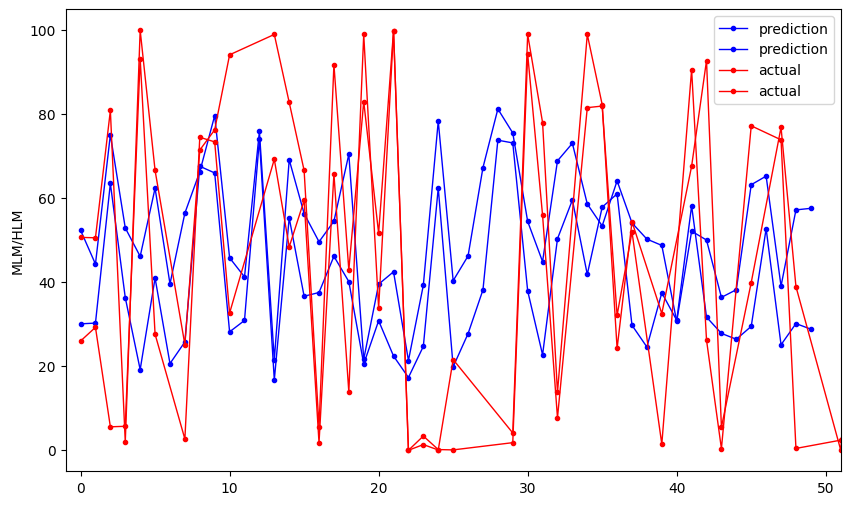

In [ ]:
# XGB_model
xgb_model_sum = XGBRegressor(random_state=seed,learning_rate=0.05)
xgb_model_sum.fit(train_sum, train_fps_label,early_stopping_rounds=5,
                  eval_set=[(valid_sum,valid_fps_label)])
pred_sum_label_xgb = xgb_model_sum.predict(valid_sum)
show_reg_result(valid_fps_label,pred_sum_label_xgb) # RMSE: 32.0078

In [ ]:
pickle.dump(rf_model_sum, open("/content/drive/MyDrive/약물대사예측/rf_model.pickle", "wb"))
pickle.dump(xgb_model_sum, open("/content/drive/MyDrive/약물대사예측/xgb_model.pickle", "wb"))

In [ ]:
class MyCNNModel(tf.keras.Model): #for vec
    def __init__(self, input_size, num_filters, kernel_size, dropout_rate, out_size):
        super(MyCNNModel, self).__init__()

        # Define the 1D convolutional layers
        self.conv1 = tf.keras.layers.Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')

        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()

        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(256,activation = 'relu')
        self.fc_out = tf.keras.layers.Dense(out_size)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.ln1(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.ln2(out)
        out = self.dropout(out)

        out = self.flatten(out)
        out = self.dense(out)
        out = self.fc_out(out)
        return out

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [ ]:
best_vec_model = MyCNNModel(input_size=len(train_vec_feature.columns), num_filters=32, kernel_size=5, dropout_rate=0.3, out_size=2)
best_vec_model.build(input_shape=(64, len(train_vec_feature.columns), 1))
best_vec_model.load_weights('/content/drive/MyDrive/약물대사예측/best_vec_model.h5')

best_vec_model.compile(optimizer='adam',loss='mse',metrics=[rmse])

pred_vec_label = best_vec_model.predict(valid_vec_feature_np)

In [ ]:
best_gcn_model = GraphConvModel(n_tasks=2, mode='regression',graph_conv_layers=[64,64],batch_size=64,random_state=seed,
                             dropout_rate=dropout,
                             dense_layer_size= 256,
                             model_dir='/content/drive/MyDrive/약물대사예측/gcn_model')

best_gcn_model.restore() #드디어...

In [ ]:
pred_conv_label =best_gcn_model.predict(valid_conv_dataset)
show_reg_result(valid_conv_dataset.y, pred_conv_label) # RMSE: 32.3855

## Ensemble

### mean

In [ ]:
def model_mean(pred_sum_label_rf,pred_sum_label_xgb,pred_vec_label,pred_conv_label,len,train=True): # 모델 합계 평균 검증용
  mlm_mean = []
  for i in range(len):
    mlm = np.mean([pred_sum_label_rf[i][0],pred_sum_label_xgb[i][0], pred_vec_label[i][0],pred_conv_label[i][0]])
    mlm_mean.append(mlm)

  hlm_mean = []
  for i in range(len):
    hlm = np.mean([pred_sum_label_rf[i][1],pred_sum_label_xgb[i][1],pred_vec_label[i][1],pred_conv_label[i][1]])
    hlm_mean.append(hlm)

  mean_df = pd.DataFrame({'MLM':mlm_mean,'HLM':hlm_mean})
  mean_numpy = mean_df.to_numpy()
  if train:
    show_reg_result(valid_conv_dataset.y, mean_numpy, N=50)
  return mean_df

MAE: 26.2361
RMSE: 30.9539
Max error: 88.563


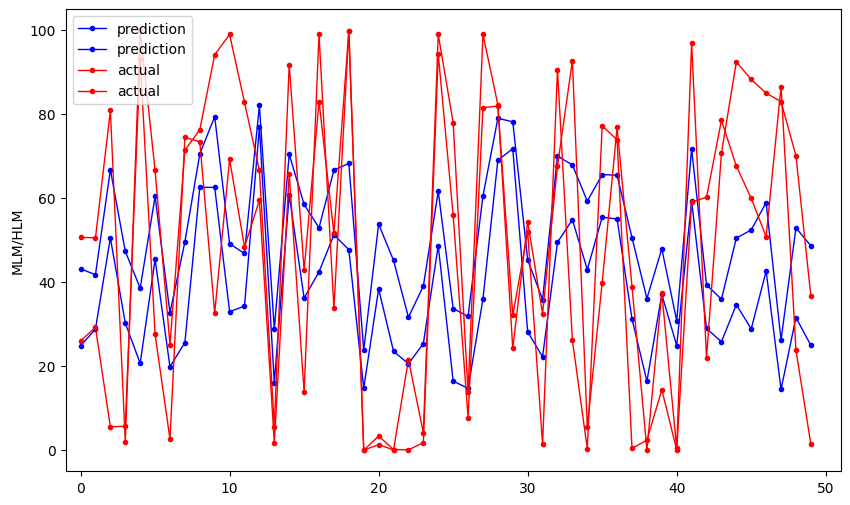

In [ ]:
mean_df = model_mean(pred_sum_label_rf,pred_sum_label_xgb,pred_vec_label,pred_conv_label,485,train=True) #RMSE: 30.9539

### stacking

In [ ]:
def model_sum(pred_sum_label,pred_sum_label_xgb,pred_vec_label,pred_conv_label,len): # 모델 합계 평균 검증용
  mlm_sum = []
  for i in range(len):
    mlm = np.array([pred_sum_label[i][0], pred_sum_label_xgb[i][0],pred_vec_label[i][0],pred_conv_label[i][0]])
    mlm_sum.append(mlm)

  hlm_sum = []
  for i in range(len):
    hlm = np.array([pred_sum_label[i][1],pred_sum_label_xgb[i][1], pred_vec_label[i][1],pred_conv_label[i][1]])
    hlm_sum.append(hlm)

  mlm_sum_np = np.vstack(mlm_sum)
  hlm_sum_np = np.vstack(hlm_sum)

  mlm_sum_df = pd.DataFrame(mlm_sum_np, columns = ['sum','xgb','vec','conv'])
  hlm_sum_df = pd.DataFrame(hlm_sum_np, columns = ['sum','xgb','vec','conv'])

  return mlm_sum_df,hlm_sum_df,

In [ ]:
def check_stacking(mlm_sum_df,hlm_sum_df):
  mlm_rmse = []
  hlm_rmse = []
  kf = KFold(n_splits = 10, random_state = seed, shuffle = True)
  for i, (train_index, valid_index) in enumerate(kf.split(mlm_sum_df)):
    train_mlm = mlm_sum_df.iloc[train_index]
    train_hlm = hlm_sum_df.iloc[train_index]
    train_mlm_label = valid_rdk_label.iloc[train_index,0]
    train_hlm_label = valid_rdk_label.iloc[train_index,1]

    valid_mlm = mlm_sum_df.iloc[valid_index]
    valid_hlm = hlm_sum_df.iloc[valid_index]
    valid_mlm_label = valid_rdk_label.iloc[valid_index,0]
    valid_hlm_label = valid_rdk_label.iloc[valid_index,1]

    reg_mlm = LinearRegression()
    reg_mlm.fit(train_mlm,train_mlm_label)
    p_mlm = reg_mlm.predict(valid_mlm)
    rmse = mean_squared_error(valid_mlm_label, p_mlm, squared=False)
    mlm_rmse.append(rmse)
    print(f'mlm_{i+1} rmse :{rmse}')

    reg_hlm = LinearRegression()
    reg_hlm.fit(train_hlm,train_hlm_label)
    p_hlm = reg_mlm.predict(valid_hlm)
    rmse = mean_squared_error(valid_hlm_label, p_hlm, squared=False)
    hlm_rmse.append(rmse)
    print(f'hlm_{i+1} rmse :{rmse} \n')

  print(f'mlm rmse :{(np.mean(mlm_rmse)):.5f}')
  print(f'hlm rmse :{(np.mean(hlm_rmse)):.5f}')
  print(f'rmse : {np.mean([(np.mean(mlm_rmse)),(np.mean(hlm_rmse))]):.5f}')

In [ ]:
mlm_sum_df,hlm_sum_df = model_sum(pred_sum_label_rf,pred_sum_label_xgb,pred_vec_label,pred_conv_label,485)
check_stacking(mlm_sum_df,hlm_sum_df)

mlm_1 rmse :35.107067677484885
hlm_1 rmse :34.34598103152256 

mlm_2 rmse :30.79243828550338
hlm_2 rmse :31.800103089617078 

mlm_3 rmse :32.26521569506182
hlm_3 rmse :32.99936361074879 

mlm_4 rmse :25.64303197965527
hlm_4 rmse :29.508653474406838 

mlm_5 rmse :25.191946859725807
hlm_5 rmse :30.265880136417152 

mlm_6 rmse :30.153863976031328
hlm_6 rmse :29.708431744072517 

mlm_7 rmse :29.039463569456288
hlm_7 rmse :27.87095081087599 

mlm_8 rmse :37.9511434003691
hlm_8 rmse :38.057862011417 

mlm_9 rmse :28.400124769335093
hlm_9 rmse :32.19299189458906 

mlm_10 rmse :27.9535749341905
hlm_10 rmse :33.36314049222684 

mlm rmse :30.24979
hlm rmse :32.01134
rmse : 31.13056


In [ ]:
# Let's stacking
reg_mlm = LinearRegression()
reg_hlm = LinearRegression()

reg_mlm.fit(mlm_sum_df,valid_fps_label.MLM)
reg_hlm.fit(hlm_sum_df,valid_fps_label.HLM)

LinearRegression()

## Test

### mean

In [ ]:
# if you need transform to numpy
test_vec_feature = test_vec.iloc[:,1:]
test_vec_feature_np = test_vec_feature.to_numpy()

# Reshape the input data to match the expected 3D shape
test_vec_feature_np =  test_vec_feature_np.reshape(test_vec_feature_np.shape[0],test_vec_feature_np.shape[1], 1)

# rdk_fps sum으로 할때
test_sum = pd.concat([test_rdk.iloc[:,1:],test_fps.iloc[:,1:]],axis=1)

In [ ]:
# test rdk_fps sum
test_sum_label_rf = rf_model_sum.predict(test_sum)
test_sum_label_xgb = xgb_model_sum.predict(test_sum)
test_vec_label = best_vec_model.predict(test_vec_feature_np)
test_conv_label = best_gcn_model.predict(test_conv_dataset)

16/16 [==============================] - 1s 33ms/step


In [ ]:
test_mean_df = model_mean(test_sum_label_rf,test_sum_label_xgb,test_vec_label,test_conv_label,len(test_sum_label_rf),train=False)

In [ ]:
test_mean_df.describe()

,MLM,HLM
count,483.000000,483.000000
mean,37.326239,53.287861
std,15.103278,14.230391
min,7.882702,18.085106
25%,25.823794,42.035124
50%,34.939462,53.102384
75%,46.492520,64.182415
max,76.446776,83.431923


In [ ]:
test_mean_df

,MLM,HLM
0,34.680231,55.937583
1,54.762217,70.426416
2,35.902223,57.902885
3,34.909132,55.316670
4,45.002878,64.022088
...,...,...
478,22.514736,41.087800
479,66.729831,77.981091
480,43.190059,55.636464
481,57.604276,67.785246


In [ ]:
df_submission = pd.read_csv("/content/drive/MyDrive/약물대사예측/sample_submission.csv")
df_submission["MLM"] = test_mean_df['MLM']
df_submission["HLM"] = test_mean_df['HLM']

model_name = 'final_Model_mean'
# 출력 형식 지정 (월/일/시간)
time =  datetime.datetime.now(pytz.timezone('Asia/Seoul')).strftime("%m%d_%H%M")

df_submission.to_csv(f"/content/drive/MyDrive/약물대사예측/DLproject_DMp_{time}_{model_name}.csv", index = False, encoding = "utf-8-sig")

### stacking

In [ ]:
test_sum_label_rf = rf_model_sum.predict(test_sum)
test_sum_label_xgb = xgb_model_sum.predict(test_sum)
test_vec_label = best_vec_model.predict(test_vec_feature_np)
test_conv_label = best_gcn_model.predict(test_conv_dataset)

16/16 [==============================] - 1s 45ms/step


In [ ]:
mlm_sum_test, hlm_sum_test = model_sum(test_sum_label_rf,test_sum_label_xgb,test_vec_label,test_conv_label,len(test_sum_label_rf))

In [ ]:
MLM_test = reg_mlm.predict(mlm_sum_test)
HLM_test = reg_hlm.predict(hlm_sum_test)
test_stack_df = pd.DataFrame({'MLM':MLM_test,'HLM':HLM_test})

In [ ]:
test_stack_df.describe()

,MLM,HLM
count,483.000000,483.000000
mean,37.073842,52.286221
std,16.744248,13.710703
min,1.823604,20.437364
25%,23.935230,41.626621
50%,35.221801,51.518875
75%,47.954909,62.577194
max,79.640631,84.145064


In [ ]:
df_submission = pd.read_csv("/content/drive/MyDrive/약물대사예측/sample_submission.csv")
df_submission["MLM"] = test_stack_df['MLM']
df_submission["HLM"] = test_stack_df['HLM']

model_name = 'final_Model_stacking'
# 출력 형식 지정 (월/일/시간)
time =  datetime.datetime.now(pytz.timezone('Asia/Seoul')).strftime("%m%d_%H%M")

df_submission.to_csv(f"/content/drive/MyDrive/약물대사예측/DLproject_DMp_{time}_{model_name}.csv", index = False, encoding = "utf-8-sig")

# Predict

In [ ]:
objects = {'rdk_featurizer_func':get_descriptor_feature,
           'fps_featurizer_class':FpsGenerator,
           'vec_featurizer_class':Mol2Vec,
           'conv_featurizer_class':ConvMol,
           'split_dataset':DataSplitter,
           'split_label':feature_label_split,
           'rf_model':rf_model_sum,
           'xgb_model':xgb_model_sum,
           'CNN_model':MyCNNModel,
           'GCN_model':best_gcn_model,
           'Model_mean':model_mean
           }

with open('/content/drive/MyDrive/약물대사예측/functions_classes.pickle', 'wb') as file:
    pickle.dump(objects, file)